# Adaptive Binning Examples



In [1]:
ciaover 
echo Today is `date`

CIAO 4.11 Wednesday, December  5, 2018
  bindir      : /export/ciao-4.11/bin
  CALDB       : 4.8.2
Today is Sun Jan 20 11:03:59 EST 2019


The following routines are available in `CIAO` to perform
adaptive binning

- [`dmnautilus`](http://cxc.harvard.edu/ciao/ahelp/dmnautilus.html) : simple quad-tree algorithm


The following are available on github as `python` scripts

- `contour_map` : follows local contours
- `dragon_scales` : overlapping shapes
- `grow_from_max` : watershed tesselations
- `hexgrid` : regular hexagonal grid
- `mkregmap` : stack of regions to a map
- `pathfinder` : steepest ascent 

There is also 

- `merge_too_small` : utility tool to help simplify the output.




These are compiled `C` tools that available on separate github repros that need to be built into your `CIAO` instalation.

- `dmnautilus` : upgrade to allow for lower threshold limits
- `dmradar` : elliptical-polar equivalent of `dmnautilus`

## Getting Started

We'll start by downloading and reprocessing the data.  We'll also grab a custom colormap to make the display more interesting and setup a helper routine to display `ds9` images in the notebook.


In [2]:
# Get a custom color map from CPT-CITY, now in ds9.sao format
curl -O http://soliton.vm.bytemark.co.uk/pub/cpt-city/neota/othr/sunset-in-atlantis.sao

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
112   673  112   673    0     0   2492      0 --:--:-- --:--:-- --:--:--  7477


In [3]:
download_chandra_obsid 9399 evt1,asol,bpix,bias,dtf,flt,fov,msk,mtl,pbk,stat


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  bpix     fits       66 Kb  ####################          < 1 s  1030.4 kb/s
  fov      fits        6 Kb  ####################          < 1 s  783.5 kb/s
  asol     fits       20 Mb  ####################          < 1 s  25534.4 kb/s
  evt1     fits      239 Mb  ####################            4 s  59633.2 kb/s
  flt      fits        7 Kb  ####################          < 1 s  233.8 kb/s
  msk      fits        5 Kb  ####################          < 1 s  701.9 kb/s
  mtl      fits        3 Mb  ####################          < 1 s  29442.6 kb/s
  stat     fits        2 Mb  ####################          < 1 s  24332.8 kb/s
  bias     fits      495 Kb  ####################          < 1 s  9281.4 kb/s
  bias     fits      452 Kb  ####################          < 1 s  11276.9 kb/s
  bias     fits      444 Kb  ####################          < 

In [4]:
chandra_repro 9399 9399/repro 2>&1 | sed s,`pwd`,.,g


Processing input directory './9399'

Resetting afterglow status bits in evt1.fits file...

Running acis_build_badpix and acis_find_afterglow to create a new bad pixel file...

Running acis_process_events to reprocess the evt1.fits file...
Output from acis_process_events:
# acis_process_events (CIAO 4.11): The following error occurred 3 times:
	dsAPEPULSEHEIGHTERR -- WARNING: pulse height is less than split threshold when performing serial CTI adjustment.
Filtering the evt1.fits file by grade and status and time...
Applying the good time intervals from the flt1.fits file...
The new evt2.fits file is: ./9399/repro/acisf09399_repro_evt2.fits

Updating the event file header with chandra_repro HISTORY record
Creating FOV file...
Setting observation-specific bad pixel file in local ardlib.par.

Cleaning up intermediate files

         ./9399/repro/acisf09399_repro_bpix1.fits
         Run 'punlearn ardlib' when analysis of this dataset completed.

The data have been reprocessed.
Start your a

In [5]:
# Create image for just CCD_ID=7
apply_fov_limits \
     infile="9399/repro/acisf09399_repro_evt2.fits[ccd_id=7,energy=200:2000]" \
     outfile=img.fits binsize=4 cl+

Running: apply_fov_limits
  version: 12 September 2016
Observation: ObsId 9399 - ACIS-23567
Using ccd_id=7 from 9399/repro/acisf09399_repro_evt2.fits[ccd_id=7,energy=200:2000]
Calculating FOV file using:
  Aspect solution 9399/repro/pcadf321296841N002_asol1.fits
  Mask file       9399/repro/acisf09399_000N002_msk1.fits

The output image will have 364 by 366 pixels, pixel size of 1.968 arcsec,
    and cover x=3532.5:4988.5:4,y=3092.5:4556.5:4.

Created: img.fits


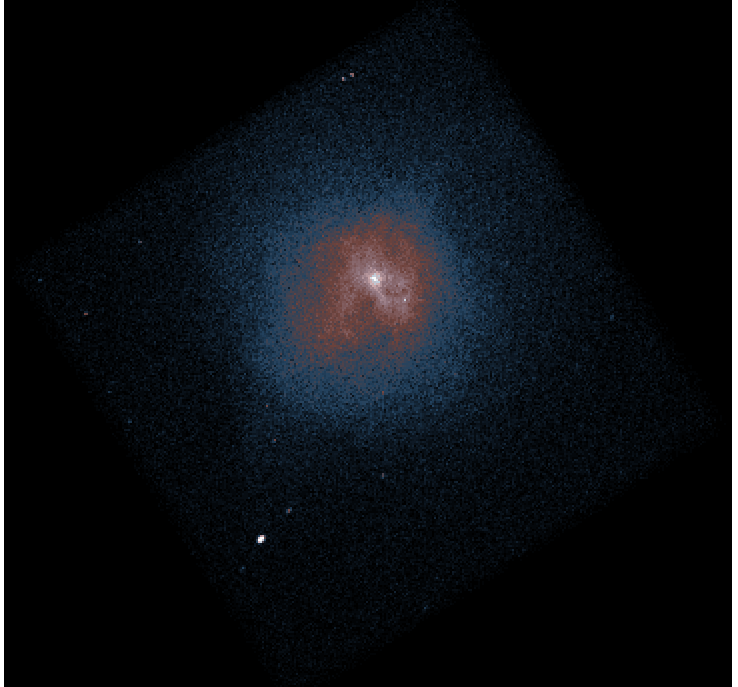

In [6]:
ds9 -scale asinh -scale limits 0 200 -zoom 2 -cmap load sunset-in-atlantis.sao  \
  -view info no -view panner no -view magnifier no -view buttons no -view colorbar no \
  img.fits \
  -saveimage png img.png -quit 

display < img.png

The updated version of the tool also respects the image subspace.  We can filter the image with 
field-of-view file, with `[opt full]` to retain the dimensions to _set_ the subspace in the image.

In [7]:
# Get FOV for just CCD_ID=7
dmcopy "9399/repro/acisf09399_repro_fov1.fits[ccd_id=7]" ccd7.fov clob+

In [12]:
dmcopy "img.fits[sky=region(ccd7.fov)][opt full]" img.dss.fits clob+

In [13]:
# Smooth image with simple 3-pixel sigma Gaussian
aconvolve img.dss.fits smimg.fits kernels="lib:gaus(2,5,5,3,3)"  \
  method=slide edges=constant const=0 clob+

In [16]:
dmimgadapt img.dss.fits img_500.asm tophat min=1 max=100 numrad=100  \
  radscale=lin counts=500 radfile=min500.map verb=2 clob+

Pre-computing convolution kernels
First iteration: determine scales and normalization

Second iteration: computing final normalized values


Adaptively smooth the input image at the size of the 95% ECF,see [thread](http://cxc.harvard.edu/ciao/threads/ttt_mkpsfmap_smoothing/), and then create the groups based on the 
remaining local maxima. 

In [17]:
# Create PSF map
mkpsfmap img.dss.fits psf.map energy=1 ecf=0.95 units=logical

# Truncate to 1 decimal place (runs faster)
dmimgcalc infile=psf.map infile2=none outfile=ipsf.map\
  operation="imgout=((int)(img1*10.0))/10.0" clob+

# Adaptively smooth
dmimgadapt infile=img.dss.fits outfile=img.psf_asm_nans function=gaussian \
  inradfile=ipsf.map mode=h clob+ verb=1
  
# Replace NaN with 0
dmimgthresh img.psf_asm_nans img.psf_asm cut=INDEF value=0 clob+

---

> **There is a bug** in `dmmaskbin` which shows up when running `grow_from_max`. 
> I have a version on my github page with the bug fixed.  
> It only shows up when the input image has pixel values set to $NaN$
> Users can replace the $NaN$ with 0 using `dmimgthresh`
> 
> `dmimgthresh img.psf_asm img.psf_asm.nonan cut=INDEF value=0`

---
